# Deep Q-Network (DQN) for Gravity-Guy Env v2 — Plan & Rationale

**Goal.** Train a DQN agent that outperforms both **Random** and our **Tiny Heuristic** on a held-out set of seeds.  
We’ll keep the notebook educational: each section explains *what we do* and *why*, before showing code.

**Notebook roadmap**
1. **DQN at a glance (this section):** problem framing & core equations (high-level, with formulas).
2. **Experiment setup:** action/obs spaces, reward, time limits, seeds, evaluation protocol, logging.
3. **Network & optimizer choices:** architecture, activations, initialization, loss, target updates, exploration.
4. **Training loop design:** replay buffer, batches, update cadence, target sync, eval cadence, checkpoints.
5. **Implementation:** minimal training code, clean metrics.
6. **Results & analysis:** curves, tables, seed-paired eval, side-by-side with heuristic.
7. **Next steps:** ablations (Double DQN, PER, n-step) and improvements.

*Environment:* GGEnv v2, Observation v2 (15-dim), discrete actions (2), default decision rate ≈ 15 Hz (`frame_skip=4`).
test

## Part 1 — DQN at a glance

### 1) Problem framing (MDP)
We model the game as a Markov Decision Process (MDP):
- **State** $s_t$: the 15-dim observation vector (player position/velocity/gravity + probe features).
- **Action** $a_t \in \{0,1\}$: `0 = NOOP`, `1 = FLIP` gravity.
- **Reward** $r_t$: scalar signal per step (defined in the setup section).
- **Transition**: environment moves platforms, applies gravity, checks collisions → $s_{t+1}$.
- **Discount** $\gamma \in [0,1)$: how much we value future rewards.

The objective is to learn a policy $\pi(a \mid s)$ that maximizes expected discounted return.

---

### 2) Q-learning objective
The **optimal action-value** function $Q^*(s,a)$ satisfies the Bellman optimality equation:

$$
Q^*(s_t,a_t) = \mathbb{E}\big[r_t + \gamma \max_{a'} Q^*(s_{t+1}, a') \,\big]
$$

DQN approximates $Q(s,a;\theta)$ with a neural network and minimizes a temporal-difference (TD) loss toward a **target**:

$$
y_t = r_t + \gamma (1 - \text{done}_t) \, \max_{a'} Q(s_{t+1}, a'; \theta^-)
$$

$$
\mathcal{L}(\theta) = \mathbb{E}\left[\, \ell\big(y_t - Q(s_t, a_t; \theta)\big) \,\right]
$$

- $\theta$: online network parameters (updated every gradient step).  
- $\theta^-$: **target network** parameters (held fixed; periodically or softly synced from $\theta$).  
- $\ell(\cdot)$: loss; we’ll use **Huber** (smooth L1) for stability:

$$
\ell(\delta)=
\begin{cases}
\tfrac{1}{2}\delta^2 & \text{if } |\delta|\le \kappa \\
\kappa\,(|\delta| - \tfrac{1}{2}\kappa) & \text{otherwise}
\end{cases}
$$

with $\kappa=1$ by default. (MSE also works but is less robust to outliers.)

> **Double DQN (optional):** reduces over-estimation by selecting with $\theta$ but evaluating with $\theta^-$:
> $$
> y_t = r_t + \gamma (1-\text{done}_t)\, Q\!\left(s_{t+1}, \arg\max_{a'} Q(s_{t+1},a';\theta);\ \theta^- \right)
> $$
> We’ll start with vanilla DQN and can switch to Double DQN if needed.

---

### 3) Experience replay & exploration
- **Replay buffer** $\mathcal{D}$: stores transitions $(s_t,a_t,r_t,s_{t+1},\text{done})$.  
  At each update, we sample a mini-batch **i.i.d.** from $\mathcal{D}$ to decorrelate updates and stabilize training.
- **$\varepsilon$-greedy exploration**: with prob. $\varepsilon_t$ choose a random action; otherwise act greedily:

$$
a_t =
\begin{cases}
\text{rand action} & \text{with prob } \varepsilon_t \\
\arg\max_a Q(s_t,a;\theta) & \text{with prob } 1-\varepsilon_t
\end{cases}
$$

We’ll **anneal** $\varepsilon$ linearly from 1.0 to 0.05 over a fixed number of decision steps.

---

### 4) Network & activation (why ReLU?)
- **Input:** 15-dim observation (already normalized/scaled by design).
- **Output:** 2 Q-values $[Q(s,NOOP),\,Q(s,FLIP)]$.
- **Backbone:** MLP with two hidden layers (e.g., **256 → 256**, **ReLU**).
  - **Why ReLU?** Simple, fast, avoids vanishing gradients, works well on sparse/tabular-like signals (our probes).
  - We’ll use **Xavier/He** initialization (framework defaults) and **Adam** optimizer (good adaptive steps).

---

### 5) Target updates & stability knobs
- **Target network sync:** either **hard** copy every $C$ updates or **soft** update  
  $\theta^- \leftarrow \tau \theta + (1-\tau)\theta^-$ with small $\tau$.
- **Gradient clipping:** cap global norm (e.g., 10) to prevent rare exploding updates.
- **Reward clipping (optional):** clip $r_t \in [-1,1]$ if rewards are unbounded.  
- **Batch size / buffer size:** large enough to decorrelate; we’ll start with batch 256, buffer 100k.

---

### 6) What “success” looks like here
- On held-out seeds, DQN surpasses both **Random** and **Tiny Heuristic** in:
  - **distance** (px), **episode length** (s),
  - **death-cause mix** (fewer early spikes *and* fewer OOB),
  - learning curves that improve steadily without divergence.


## Part 2 — Experiment setup & evaluation protocol

**Goal.** Fix all the “contract” details before writing any training code so results are reproducible and comparable.

### 1) Environment contract
- **Env:** `GGEnv v2` (Observation v2, 15-dim).
- **Actions:** discrete {0 = NOOP, 1 = FLIP}.
- **Decision cadence:** `frame_skip = 4` ⇒ ~15 decisions/sec at 60 FPS physics.
- **Time limit:** 30 s simulated per episode ⇒ **max_steps ≈ 450** decisions.
- **Seeding:** full determinism per episode seed (and per-run RNG seeds).

> We’ll keep the env reward as-is (alive reward per decision, small terminal penalty if defined).  
> Our *primary* evaluation metrics remain **distance (px)** and **episode length (s)**.

### 2) Datasets: training vs evaluation seeds
- **Eval seeds (held-out):** reuse the 20 seeds from the sanity notebook (101–120).  
  We never train on these; we only evaluate on them periodically and at the end.
- **Training seeds:** a larger pool (e.g., 1000–1999) sampled per episode to avoid overfitting.

### 3) Logging & folders (so replay works)
We’ll log under `experiments/runs/dqn/<run_id>/`:
- `config.json` — all hyperparams & seeds
- `metrics.csv` — rolling train stats (loss, eps, steps, buffer size, etc.)
- `eval/episodes.csv` — eval summaries on the held-out seeds
- `eval/traces/<seed>_actions.npy` — action sequences for exact replay
- `checkpoints/` — network snapshots (e.g., best and periodic)

### 4) Hyperparameters (first pass; we’ll freeze them in Part 3)
- Network: MLP 2×256, ReLU, output dimension = 2 Q-values
- Optimizer: Adam (lr = 1e-3), Huber loss, γ = 0.99
- Replay buffer: 100k, batch = 256
- Train every 4 decisions; target sync every 1,000 updates
- ε-greedy: 1.0 → 0.05 linearly over ~100k decisions

We’ll confirm/adjust these after a small smoke run.


In [2]:
# Make the repo root (the folder that contains `src/`) importable
import sys
from pathlib import Path

# Start from the current notebook dir and walk upwards until we find a 'src' folder
here = Path.cwd().resolve()
repo_root = None
for parent in [here, *here.parents]:
    if (parent / "src").exists():
        repo_root = parent
        break

if repo_root is None:
    raise FileNotFoundError(
        f"Couldn't find a 'src' directory by walking up from {here}. "
        "Open this notebook from inside your repo or adjust the path below manually."
    )

# Put repo root at the front of sys.path
sys.path.insert(0, str(repo_root))
print("Added to sys.path:", repo_root)

# Optional: ensure packages are recognized (create empty __init__.py if missing)
for pkg in ["src", "src/env", "src/game"]:
    init = repo_root / pkg / "__init__.py"
    if not init.exists():
        try:
            init.touch()
            print("Created", init)
        except Exception as e:
            print("Note:", init, "does not exist and couldn't be created automatically:", e)

# Sanity import
from src.env.gg_env_v2 import GGEnv
print("Import OK:", GGEnv)


Added to sys.path: D:\Projects\GravityGuyML
Created D:\Projects\GravityGuyML\src\__init__.py
Import OK: <class 'src.env.gg_env_v2.GGEnv'>


In [3]:
import os, random, json, time
from pathlib import Path
import numpy as np

import gymnasium as gym
from src.env.gg_env_v2 import GGEnv

# ----- Paths (assuming notebook in experiments/notebooks/) -----
NOTEBOOK_DIR = Path.cwd()
EXP_DIR = NOTEBOOK_DIR.parent                   # experiments/
RUNS_BASE = EXP_DIR / "runs" / "dqn"            # experiments/runs/dqn/
RUNS_BASE.mkdir(parents=True, exist_ok=True)

# Unique run id (timestamp) and run directory
RUN_ID = time.strftime("%Y%m%d_%H%M%S")
RUN_DIR = RUNS_BASE / RUN_ID
(RUN_DIR / "eval" / "traces").mkdir(parents=True, exist_ok=True)
(RUN_DIR / "checkpoints").mkdir(parents=True, exist_ok=True)
print("Run dir:", RUN_DIR)

# ----- Core env settings -----
SIM_FPS = 60
FRAME_SKIP = 4
DECISION_HZ = SIM_FPS / FRAME_SKIP
TIME_LIMIT_S = 30
MAX_STEPS = int(TIME_LIMIT_S * DECISION_HZ)

# ----- Seed sets -----
EVAL_SEEDS = list(range(101, 121))               # held-out
TRAIN_SEED_RANGE = (1000, 2000)                  # sampled per episode

# ----- Global RNG seeds for reproducibility (you can change these) -----
GLOBAL_SEED = 42
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)

print(f"Decision rate ≈ {DECISION_HZ:.1f} Hz; max_steps = {MAX_STEPS}")
print(f"Eval seeds ({len(EVAL_SEEDS)}): {EVAL_SEEDS[0]}..{EVAL_SEEDS[-1]}")
print(f"Train seed range: [{TRAIN_SEED_RANGE[0]}, {TRAIN_SEED_RANGE[1]})")

# ----- Small helper: env factory -----
def make_env(seed: int, render_mode=None):
    """
    Create a GGEnv v2 with the agreed contract.
    We keep render_mode=None for training and 'human' for debug runs.
    """
    env = GGEnv(render_mode=render_mode, frame_skip=FRAME_SKIP)
    # Let env carry its own time limit; if you need a hard cap, wrap with gym.wrappers.TimeLimit
    obs, info = env.reset(seed=seed)
    return env

# Sanity: instantiate once headless (no window), check spaces
_env = make_env(seed=EVAL_SEEDS[0], render_mode=None)
print("Obs space:", _env.observation_space)
print("Act space:", _env.action_space)
_env.close()

# Save a tiny config snapshot for the run folder now
config_snapshot = {
    "run_id": RUN_ID,
    "sim_fps": SIM_FPS,
    "frame_skip": FRAME_SKIP,
    "decision_hz": DECISION_HZ,
    "time_limit_s": TIME_LIMIT_S,
    "max_steps": MAX_STEPS,
    "eval_seeds": EVAL_SEEDS,
    "train_seed_range": TRAIN_SEED_RANGE,
    "global_seed": GLOBAL_SEED,
}
with (RUN_DIR / "config.json").open("w") as f:
    json.dump(config_snapshot, f, indent=2)
print("Wrote:", RUN_DIR / "config.json")


Run dir: d:\Projects\GravityGuyML\experiments\runs\dqn\20250911_015257
Decision rate ≈ 15.0 Hz; max_steps = 450
Eval seeds (20): 101..120
Train seed range: [1000, 2000)
Obs space: Box([ 0. -1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.], 1.0, (15,), float32)
Act space: Discrete(2)
Wrote: d:\Projects\GravityGuyML\experiments\runs\dqn\20250911_015257\config.json


## Part 3 — Network & optimizer choices

### Architecture (DQN head)
- **Input:** 15-dim observation (obs v2).
- **Output:** 2 Q-values $[Q(s,\text{NOOP}),\, Q(s,\text{FLIP})]$.
- **Backbone:** MLP with two hidden layers: **256 → 256**, **ReLU** activations.

**Why ReLU?**  
Simple, fast, robust to vanishing gradients, and works well on sparse/tabular-ish inputs (our probe features). PyTorch’s default Kaiming/He initialization is designed for ReLU.

### Loss & targets
- **TD target:** $ y_t = r_t + \gamma (1 - \text{done}_t)\max_{a'} Q(s_{t+1}, a'; \theta^-) $
- **Loss:** **Huber (smooth L1)** on $(y_t - Q(s_t,a_t;\theta))$ for outlier robustness.
- **Target network:** copy online → target every **C = 1000** updates (hard sync).  
  *(We can switch to soft updates or Double DQN later if needed.)*

### Optimizer & stability
- **Optimizer:** Adam, **lr = 1e-3**.
- **Discount:** $\gamma = 0.99$.
- **Gradient clipping:** global-norm cap **10.0** to avoid rare spikes.
- **Replay buffer:** **100k** transitions; **batch = 256**; train every **4** decisions.
- **Warmup:** collect **5k** decisions with pure exploration before first gradient step.

### Exploration (ε-greedy)
- Start **ε=1.0**, linearly anneal to **ε=0.05** over **100k** decisions:

$$
\varepsilon_t = \max\big(\varepsilon_{\min}, \varepsilon_{\max} - (\varepsilon_{\max}-\varepsilon_{\min}) \cdot t / T\big)
$$

where $T = 100{,}000$ decisions.

### What success should look like
- On held-out seeds, the trained DQN surpasses **Random** and the **Tiny Heuristic** in **distance** and **episode length**, and reduces both **early spikes** and **OOB** deaths.


In [4]:
# Part 3 — minimal config + model skeleton (no training yet)

import json, math
from dataclasses import dataclass
from typing import Sequence
import torch
import torch.nn as nn
import torch.nn.functional as F

# ---- DQN config (kept small & explicit) ----
CFG = {
    "obs_dim": 15,
    "num_actions": 2,
    "hidden_sizes": [256, 256],
    "gamma": 0.99,
    "lr": 1e-3,
    "batch_size": 256,
    "replay_size": 100_000,
    "train_every": 4,           # gradient step every N decisions
    "target_update_every": 1_000,
    "grad_clip_norm": 10.0,
    "warmup_steps": 5_000,
    "eps_start": 1.0,
    "eps_end": 0.05,
    "eps_decay_steps": 100_000,
    # bookkeeping (can be overridden later)
    "total_decisions": 1_000_000,   # overall training budget (decisions)
    "eval_every": 50_000,           # evaluate on held-out seeds every N decisions
    "seed": 42,
}

# Save/merge into the run config file created earlier
cfg_path = RUN_DIR / "config.json"
try:
    current = json.loads(cfg_path.read_text()) if cfg_path.exists() else {}
except Exception:
    current = {}
current.update({"dqn_cfg": CFG})
cfg_path.write_text(json.dumps(current, indent=2))
print("Updated config:", cfg_path)

# ---- Device selection ----
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Torch device:", DEVICE)

# ---- Epsilon schedule helper ----
def epsilon_at(step: int, start=CFG["eps_start"], end=CFG["eps_end"], decay=CFG["eps_decay_steps"]):
    if decay <= 0:
        return end
    frac = min(1.0, max(0.0, step / decay))
    return float(start + (end - start) * frac)

# quick sanity check for eps schedule
print("ε(0) =", epsilon_at(0), "  ε(50k) =", epsilon_at(50_000), "  ε(100k) =", epsilon_at(100_000))

# ---- Minimal Q-network skeleton ----
class QNetwork(nn.Module):
    def __init__(self, obs_dim: int, num_actions: int, hidden: Sequence[int] = (256, 256)):
        super().__init__()
        layers = []
        last = obs_dim
        for h in hidden:
            layers += [nn.Linear(last, h), nn.ReLU()]
            last = h
        layers += [nn.Linear(last, num_actions)]
        self.net = nn.Sequential(*layers)

        # (Optional) you could custom-initialize here; PyTorch defaults are fine for ReLU MLPs.

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

# Instantiate online and target nets
q_online = QNetwork(CFG["obs_dim"], CFG["num_actions"], CFG["hidden_sizes"]).to(DEVICE)
q_target = QNetwork(CFG["obs_dim"], CFG["num_actions"], CFG["hidden_sizes"]).to(DEVICE)
q_target.load_state_dict(q_online.state_dict())  # initial hard sync
for p in q_target.parameters():
    p.requires_grad_(False)

# Optimizer
optimizer = torch.optim.Adam(q_online.parameters(), lr=CFG["lr"])

# Simple parameter count & dry forward
def count_params(m: nn.Module) -> int:
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

print(f"QNetwork params: {count_params(q_online):,}")

# Dry run forward pass with a dummy observation
with torch.no_grad():
    dummy = torch.zeros(1, CFG["obs_dim"], device=DEVICE)
    q_vals = q_online(dummy)
    print("Output shape (should be [1, num_actions]):", tuple(q_vals.shape))


Updated config: d:\Projects\GravityGuyML\experiments\runs\dqn\20250911_015257\config.json
Torch device: cpu
ε(0) = 1.0   ε(50k) = 0.525   ε(100k) = 0.050000000000000044
QNetwork params: 70,402
Output shape (should be [1, num_actions]): (1, 2)


## Part 4 — Training loop design

### 1) Replay buffer API (off-policy)
We store transitions $(s_t, a_t, r_t, s_{t+1}, \text{done}_t)$ in a **fixed-size ring buffer**:
- `add(s, a, r, s_next, done)`
- `can_sample(batch_size) -> bool`
- `sample(batch_size, device) -> torch tensors`

Why: decorrelates updates, stabilizes TD learning, and lets us train **off-policy**.

---

### 2) Update cadence
We separate **environment steps** (“decisions”) from **gradient updates**:

- **Every decision step:**  
  - pick action by **ε-greedy** using $Q(s;\theta)$  
  - step the env → get $(r, s')$, push into replay  
  - if `step % train_every == 0` **and** replay has enough samples **and** after a warmup → do **one** gradient update.

- **One gradient update:**  
  - sample a minibatch,  
  - compute TD targets with the **target network**,  
  - **Huber loss** on $(y - Q(s,a))$,  
  - backprop + **grad clip** (global-norm),  
  - periodically **hard-sync** target: $\theta^- \leftarrow \theta$.

---

### 3) Target updates
- **Hard copy** every **1,000** gradient updates (default).  
  This stabilizes the bootstrap without adding extra hyperparameters.

*(Later we can swap to **soft** or **Double DQN** without changing the buffer.)*

---

### 4) Evaluation cadence & logging (coming next)
- Every **N decisions** (e.g., 50k), run **eval episodes** on the **held-out seeds** (101–120).  
- Log:
  - train: steps, ε, loss, mean Q, buffer size;  
  - eval: `episodes.csv` in `experiments/runs/dqn/<run_id>/eval/`;  
  - traces: save `*_actions.npy` so our replay tool works out-of-the-box.

In this part we’ll implement the **buffer** and **update hooks** (no full loop yet), so they’re testable and ready to be called by the training loop in the next part.


In [5]:
# Part 4 — replay buffer + ε-greedy + TD update hooks (no full training loop yet)

from dataclasses import dataclass
from typing import Dict, Tuple
import numpy as np
import torch
import torch.nn.functional as F

# ---- Replay buffer (ring) ----
class ReplayBuffer:
    def __init__(self, obs_dim: int, capacity: int):
        self.obs = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.next_obs = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.actions = np.zeros((capacity,), dtype=np.int64)
        self.rewards = np.zeros((capacity,), dtype=np.float32)
        self.dones = np.zeros((capacity,), dtype=np.bool_)
        self.capacity = capacity
        self.size = 0
        self.idx = 0

    def add(self, s: np.ndarray, a: int, r: float, s_next: np.ndarray, done: bool):
        self.obs[self.idx] = s
        self.next_obs[self.idx] = s_next
        self.actions[self.idx] = a
        self.rewards[self.idx] = r
        self.dones[self.idx] = done
        self.idx = (self.idx + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def __len__(self):
        return self.size

    def can_sample(self, batch_size: int) -> bool:
        return self.size >= batch_size

    def sample(self, batch_size: int, device: torch.device) -> Dict[str, torch.Tensor]:
        idxs = np.random.randint(0, self.size, size=batch_size)
        batch = {
            "s": torch.as_tensor(self.obs[idxs], device=device),
            "a": torch.as_tensor(self.actions[idxs], device=device),
            "r": torch.as_tensor(self.rewards[idxs], device=device),
            "ns": torch.as_tensor(self.next_obs[idxs], device=device),
            "d": torch.as_tensor(self.dones[idxs].astype(np.float32), device=device),
        }
        return batch

# Instantiate a global buffer (uses CFG and DEVICE from Part 3)
replay = ReplayBuffer(obs_dim=CFG["obs_dim"], capacity=CFG["replay_size"])
print("Replay buffer ready — capacity:", replay.capacity)

# ---- ε-greedy policy ----
def select_action_eps_greedy(q_net, obs_np: np.ndarray, eps: float, device: torch.device) -> int:
    """
    obs_np: shape (obs_dim,), numpy float32
    """
    if np.random.rand() < eps:
        return int(np.random.randint(0, CFG["num_actions"]))
    with torch.no_grad():
        x = torch.as_tensor(obs_np, device=device).unsqueeze(0)  # [1, obs_dim]
        q = q_net(x)                                            # [1, num_actions]
        a = int(torch.argmax(q, dim=1).item())
    return a

# ---- TD update (one gradient step) ----
def dqn_update_step(batch: Dict[str, torch.Tensor]) -> Dict[str, float]:
    """
    Performs a single DQN gradient step using global q_online / q_target / optimizer.
    Returns small dict of scalars for logging.
    """
    s, a, r, ns, d = batch["s"], batch["a"], batch["r"], batch["ns"], batch["d"]

    # Q(s,a)
    q_all = q_online(s)                               # [B, A]
    q_sa = q_all.gather(1, a.view(-1,1)).squeeze(1)   # [B]

    # max_a' Q_target(s', a')
    with torch.no_grad():
        q_next = q_target(ns)                         # [B, A]
        max_q_next, _ = q_next.max(dim=1)            # [B]
        y = r + CFG["gamma"] * (1.0 - d) * max_q_next

    # Huber loss
    loss = F.smooth_l1_loss(q_sa, y)

    optimizer.zero_grad()
    loss.backward()
    # gradient clipping
    if CFG["grad_clip_norm"] is not None:
        torch.nn.utils.clip_grad_norm_(q_online.parameters(), CFG["grad_clip_norm"])
    optimizer.step()

    # small stats
    with torch.no_grad():
        td_err = (y - q_sa).abs().mean().item()
        q_mean = q_all.mean().item()

    return {"loss": float(loss.item()), "td_err": td_err, "q_mean": q_mean}

# ---- Target sync helper ----
_update_counter = 0  # gradient-update counter

def maybe_sync_target():
    global _update_counter
    _update_counter += 1
    if _update_counter % CFG["target_update_every"] == 0:
        q_target.load_state_dict(q_online.state_dict())
        return True
    return False

# ---- Env interaction hook (one decision step) ----
def step_env_once(env, obs_np: np.ndarray, global_step: int) -> Tuple[np.ndarray, float, bool, Dict]:
    """
    Takes one ε-greedy action in the env, pushes transition to replay,
    optionally runs a gradient update if conditions are met.
    Returns: next_obs, reward, done, info
    """
    eps = epsilon_at(global_step)
    a = select_action_eps_greedy(q_online, obs_np, eps, DEVICE)
    obs_next, r, term, trunc, info = env.step(a)
    done = bool(term or trunc)

    # Store transition
    replay.add(s=obs_np.astype(np.float32), a=a, r=float(r),
               s_next=obs_next.astype(np.float32), done=done)

    # Optional training step
    logs = {}
    if (global_step >= CFG["warmup_steps"]
        and (global_step % CFG["train_every"] == 0)
        and replay.can_sample(CFG["batch_size"])):
        batch = replay.sample(CFG["batch_size"], DEVICE)
        logs = dqn_update_step(batch)
        if maybe_sync_target():
            logs["target_sync"] = True

    # You can return logs to append into a CSV later
    return obs_next, float(r), done, info, logs

print("Scaffold ready: ReplayBuffer, ε-greedy, TD update, target sync, step_env_once().")


Replay buffer ready — capacity: 100000
Scaffold ready: ReplayBuffer, ε-greedy, TD update, target sync, step_env_once().


## Part 5 — Minimal training loop (smoke test)

**What this does**
- Runs DQN with ε-greedy policy.
- Trains every `train_every=4` decisions after a warmup (`warmup_steps=5k`).
- Hard-syncs target network every `1,000` gradient updates.
- Logs **per-decision** stats to `experiments/runs/dqn/<run_id>/metrics.csv`.

**Why this step**
- Validate the end-to-end loop (env ↔ buffer ↔ updates ↔ logging).
- Confirm key scalars behave sanely:
  - `eps` should **decrease** from 1.0 → 0.05,
  - `loss`/`td_err` should trend **down** (noisy),
  - `q_mean` should become **finite/stable**,
  - `buffer_size` grows to capacity,
  - no crashes / NaNs.

**What not included yet**
- No evaluation on held-out seeds.
- No checkpoints.
- No fancy logging UI. (We’ll add eval + traces + a tiny plot in the next parts.)

> Tip: start with a small decision budget (e.g., **20k**). If it runs cleanly, increase later.


In [ ]:
# Part 5 — minimal training loop (smoke test)

import csv, math, time, random
from pathlib import Path
import numpy as np

# Uses: CFG, RUN_DIR, make_env, epsilon_at, step_env_once, replay, DEVICE
METRICS_CSV = RUN_DIR / "metrics.csv"

# --- Config knobs for the smoke test ---
TRAIN_DECISIONS = 20_000       # total decision steps to run now
PRINT_EVERY = 1_000            # console progress cadence
FLUSH_EVERY = 1_000            # how often to flush metrics to disk

# --- Metrics writer (append) ---
metrics_fields = [
    "global_step","episode","eps",
    "loss","td_err","q_mean",
    "reward","ep_return","ep_len",
    "buffer_size","grad_updates","target_sync",
    "seed"
]
if not METRICS_CSV.exists():
    with METRICS_CSV.open("w", newline="") as f:
        csv.DictWriter(f, fieldnames=metrics_fields).writeheader()

def write_rows(rows):
    if not rows: return
    with METRICS_CSV.open("a", newline="") as f:
        w = csv.DictWriter(f, fieldnames=metrics_fields)
        for r in rows:
            w.writerow(r)

# --- Helper to sample a training seed ---
def sample_train_seed(lo, hi):
    return random.randint(lo, hi-1)

# --- Training state ---
global_step = 0
grad_updates = 0
episode_idx = 0
rows_buffer = []

# Reuse a single env; reset with a new seed each episode
env = make_env(seed=sample_train_seed(*TRAIN_SEED_RANGE), render_mode=None)
obs, info = env.reset(seed=sample_train_seed(*TRAIN_SEED_RANGE))

ep_return = 0.0
ep_len = 0
ep_seed = info.get("seed", None) if isinstance(info, dict) else None

t0 = time.time()
try:
    while global_step < TRAIN_DECISIONS:
        eps = epsilon_at(global_step)

        # One decision step through env; logs may include loss/td_err/q_mean/target_sync
        obs_next, r, done, info, logs = step_env_once(env, obs, global_step)
        global_step += 1
        ep_return += r
        ep_len += 1

        # Track gradient update count
        if "loss" in logs:
            grad_updates += 1

        # Prepare one row (loss/q may be absent before warmup)
        row = {
            "global_step": global_step,
            "episode": episode_idx,
            "eps": eps,
            "loss": logs.get("loss", float("nan")),
            "td_err": logs.get("td_err", float("nan")),
            "q_mean": logs.get("q_mean", float("nan")),
            "reward": r,
            "ep_return": ep_return,
            "ep_len": ep_len,
            "buffer_size": len(replay),
            "grad_updates": grad_updates,
            "target_sync": int(bool(logs.get("target_sync", False))),
            "seed": ep_seed if ep_seed is not None else "",
        }
        rows_buffer.append(row)

        # Episode end → reset with a new training seed
        if done:
            episode_idx += 1
            obs, info = env.reset(seed=sample_train_seed(*TRAIN_SEED_RANGE))
            ep_seed = info.get("seed", None) if isinstance(info, dict) else None
            ep_return = 0.0
            ep_len = 0
        else:
            obs = obs_next

        # Flush & print progress
        if (global_step % FLUSH_EVERY) == 0 or global_step == TRAIN_DECISIONS:
            write_rows(rows_buffer)
            rows_buffer.clear()

        if (global_step % PRINT_EVERY) == 0:
            dt = time.time() - t0
            sps = global_step / max(1e-6, dt)
            latest_loss = row["loss"]
            print(f"[{global_step:>7d}] eps={eps:5.3f} loss={latest_loss:8.5f} "
                  f"buffer={len(replay):6d} updates={grad_updates:6d}  {sps:6.1f} steps/s")
            
        if global_step % CFG["eval_every"] == 0 and global_step > 0:
            eval_suite(global_step=global_step, seeds=EVAL_SEEDS)
            # (Optional) save a checkpoint too)
            torch.save(q_online.state_dict(), RUN_DIR / "checkpoints" / f"step_{global_step}.pt")

finally:
    # Final flush and close
    write_rows(rows_buffer)
    env.close()
    print("Wrote metrics to:", METRICS_CSV)


[   1000] eps=0.991 loss=     nan buffer=  1000 updates=     0  2825.6 steps/s
[   2000] eps=0.981 loss=     nan buffer=  2000 updates=     0  4274.4 steps/s
[   3000] eps=0.972 loss=     nan buffer=  3000 updates=     0  5120.3 steps/s
[   4000] eps=0.962 loss=     nan buffer=  4000 updates=     0  5575.6 steps/s
[   5000] eps=0.953 loss=     nan buffer=  5000 updates=     0  5938.9 steps/s
[   6000] eps=0.943 loss=     nan buffer=  6000 updates=   250  2553.3 steps/s
[   7000] eps=0.934 loss=     nan buffer=  7000 updates=   500  2254.1 steps/s
[   8000] eps=0.924 loss=     nan buffer=  8000 updates=   750  2120.7 steps/s
[   9000] eps=0.915 loss=     nan buffer=  9000 updates=  1000  2023.4 steps/s
[  10000] eps=0.905 loss=     nan buffer= 10000 updates=  1250  1947.8 steps/s
[  11000] eps=0.896 loss=     nan buffer= 11000 updates=  1500  1873.5 steps/s
[  12000] eps=0.886 loss=     nan buffer= 12000 updates=  1750  1808.8 steps/s
[  13000] eps=0.877 loss=     nan buffer= 13000 upda

In [7]:
import pandas as pd
import numpy as np

m = pd.read_csv(RUN_DIR / "metrics.csv")

print("Rows (decisions) logged:", len(m))
print("Columns:", list(m.columns))

# When did updates start?
m["has_update"] = m["loss"].notna() & np.isfinite(m["loss"])
if m["has_update"].any():
    first_upd = int(m.loc[m["has_update"], "global_step"].min())
else:
    first_upd = None
print("First gradient update step:", first_upd)

# Epsilon & buffer size
print("Last epsilon:", float(m["eps"].iloc[-1]))
print("Last buffer_size:", int(m["buffer_size"].iloc[-1]))

# Recent update stats (last 5k decisions where we have updates)
recent = m[m["has_update"]].tail(5000)
def sdesc(x):
    x = pd.to_numeric(x, errors="coerce")
    return dict(count=int(x.notna().sum()),
                mean=float(x.mean()),
                p50=float(x.median()),
                p10=float(x.quantile(0.10)),
                p90=float(x.quantile(0.90)))
if len(recent) > 0:
    print("\nRecent (where updates present, last 5k decisions):")
    print("  loss:", sdesc(recent["loss"]))
    print("  td_err:", sdesc(recent["td_err"]))
    print("  q_mean:", sdesc(recent["q_mean"]))
else:
    print("\nNo updates yet in the last 5k decisions (still in warmup or logging issue).")

# Episode-level rollup: take last row per episode
epi = (m.groupby("episode", as_index=False)
         .tail(1)[["episode","ep_len","ep_return","global_step","seed"]]
         .sort_values("episode")
         .reset_index(drop=True))
print("\nEpisodes completed:", len(epi))
if len(epi) > 0:
    # Rolling window to smooth (20 episodes)
    epi["roll_len"] = epi["ep_len"].rolling(20, min_periods=5).mean()
    epi["roll_ret"] = epi["ep_return"].rolling(20, min_periods=5).mean()
    print("Last 5 episodes (len, return):")
    print(epi[["episode","ep_len","ep_return","roll_len","roll_ret"]].tail(5).to_string(index=False))


Rows (decisions) logged: 20000
Columns: ['global_step', 'episode', 'eps', 'loss', 'td_err', 'q_mean', 'reward', 'ep_return', 'ep_len', 'buffer_size', 'grad_updates', 'target_sync', 'seed']
First gradient update step: 5001
Last epsilon: 0.8100095
Last buffer_size: 20000

Recent (where updates present, last 5k decisions):
  loss: {'count': 3750, 'mean': 0.02242309004659178, 'p50': 0.0174969276413321, 'p10': 0.00058035725378429, 'p90': 0.047825971245765604}
  td_err: {'count': 3750, 'mean': 0.053375539513677316, 'p50': 0.0398988854140043, 'p10': 0.02075867932289837, 'p90': 0.0795592375099659}
  q_mean: {'count': 3750, 'mean': 2.4065929028381903, 'p50': 2.03800106048584, 'p10': 1.0363615989685058, 'p90': 3.9599459409713744}

Episodes completed: 139
Last 5 episodes (len, return):
 episode  ep_len  ep_return  roll_len  roll_ret
     134     227      225.0    139.55    137.55
     135     428      426.0    156.25    154.25
     136     182      180.0    159.40    157.40
     137     175      

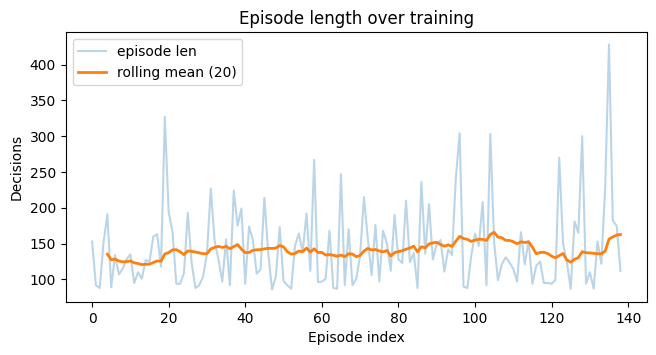

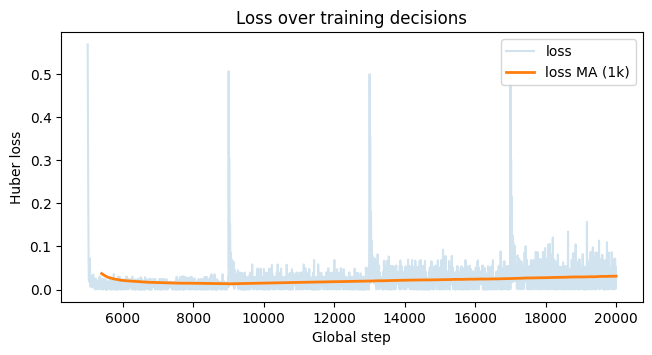

In [8]:
import matplotlib.pyplot as plt

# 1) Rolling episode length
if len(epi) > 0:
    plt.figure(figsize=(7.5,3.5))
    plt.plot(epi["episode"], epi["ep_len"], alpha=0.3, label="episode len")
    plt.plot(epi["episode"], epi["roll_len"], linewidth=2, label="rolling mean (20)")
    plt.title("Episode length over training")
    plt.xlabel("Episode index")
    plt.ylabel("Decisions")
    plt.legend()
    plt.show()

# 2) Loss over time (only where updates exist)
upd = m[m["has_update"]].copy()
if len(upd) > 0:
    upd["loss_ma"] = upd["loss"].rolling(1000, min_periods=100).mean()
    plt.figure(figsize=(7.5,3.5))
    plt.plot(upd["global_step"], upd["loss"], alpha=0.2, label="loss")
    plt.plot(upd["global_step"], upd["loss_ma"], linewidth=2, label="loss MA (1k)")
    plt.title("Loss over training decisions")
    plt.xlabel("Global step")
    plt.ylabel("Huber loss")
    plt.legend()
    plt.show()


### Part 6: Evaluation on held-out seeds (with traces)

**What this does**

* Every N decisions (e.g., `eval_every=50k`) we **freeze the current Q-network** and run **greedy episodes** (ε=0) on the **held-out seeds** (101–120).
* For each episode we log a row to `experiments/runs/dqn/<run_id>/eval/episodes.csv` with the same core fields as the sanity rollout (distance, episode\_len\_decisions, death\_cause, grounded\_ratio, etc.).
* We also save the **exact action sequence** per seed under `…/eval/traces/step_<global>_seed_<seed>.npy`, so you can replay it with your `experiments/replay.py`.

**Why this matters**

* It gives a **comparable scoreboard** vs Random/Heuristic.
* Traces make debugging easy: you can visually inspect *how* the current agent failed/succeeded.

**Greedy policy for eval**

$$
a_t = \arg\max_a Q(s_t,a;\theta) \quad (\varepsilon=0)
$$

No exploration noise during evaluation.

---

### Code — evaluation helpers + one quick test run (5 seeds)

In [9]:
# Part 6 — evaluation suite (greedy) + traces

import csv
import numpy as np
from pathlib import Path

EVAL_DIR = RUN_DIR / "eval"
EVAL_DIR.mkdir(parents=True, exist_ok=True)
TRACES_DIR = EVAL_DIR / "traces"
TRACES_DIR.mkdir(parents=True, exist_ok=True)

EPISODES_CSV = EVAL_DIR / "episodes.csv"
EPISODE_FIELDS = [
    "run_id","global_step",
    "policy_name","seed",
    "frame_skip","sim_fps","decision_hz",
    "episode_len_decisions","return_sum","distance_px",
    "terminated","truncated","death_cause","grounded_ratio"
]
if not EPISODES_CSV.exists():
    with EPISODES_CSV.open("w", newline="") as f:
        csv.DictWriter(f, fieldnames=EPISODE_FIELDS).writeheader()

def greedy_action(obs_np: np.ndarray) -> int:
    with torch.no_grad():
        x = torch.as_tensor(obs_np, device=DEVICE).unsqueeze(0)
        q = q_online(x)
        return int(torch.argmax(q, dim=1).item())

def eval_one_seed(seed: int, global_step: int) -> dict:
    env = make_env(seed=seed, render_mode=None)
    obs, info = env.reset(seed=seed)

    actions = []
    ep_return = 0.0
    grounded_steps = 0
    steps = 0
    done = False
    last_info = {}

    while not done and steps < MAX_STEPS:
        a = greedy_action(obs)
        obs, r, term, trunc, info = env.step(a)
        done = bool(term or trunc)
        actions.append(a)
        ep_return += float(r)
        grounded_steps += int(bool(info.get("grounded", False)))
        steps += 1
        last_info = info

    env.close()

    # Distance (prefer env's info; fallback to kinematics)
    distance_px = float(
        last_info.get("distance_px",
                      steps * (SCROLL_PX_PER_S := getattr(__import__("src.game.config", fromlist=["SCROLL_PX_PER_S"]), "SCROLL_PX_PER_S"))
                      / DECISION_HZ)
    )
    grounded_ratio = (grounded_steps / steps) if steps > 0 else 0.0

    # Save trace for replay
    trace_path = TRACES_DIR / f"step_{global_step}_seed_{seed}.npy"
    np.save(trace_path, np.asarray(actions, dtype=np.int64))

    row = {
        "run_id": RUN_ID,
        "global_step": global_step,
        "policy_name": "dqn_greedy",
        "seed": seed,
        "frame_skip": FRAME_SKIP,
        "sim_fps": SIM_FPS,
        "decision_hz": DECISION_HZ,
        "episode_len_decisions": steps,
        "return_sum": ep_return,
        "distance_px": distance_px,
        "terminated": int(bool(last_info.get("terminated", False))),
        "truncated": int(bool(last_info.get("truncated", False))),
        "death_cause": last_info.get("death_cause", ""),
        "grounded_ratio": grounded_ratio,
    }

    with EPISODES_CSV.open("a", newline="") as f:
        csv.DictWriter(f, fieldnames=EPISODE_FIELDS).writerow(row)

    print(f"[eval] seed={seed}  steps={steps}  dist={distance_px:.1f}  "
          f"cause={row['death_cause'] or ('trunc' if row['truncated'] else 'term')}")
    print(f"       trace → {trace_path}")
    return row

def eval_suite(global_step: int, seeds=EVAL_SEEDS):
    print(f"\n=== EVAL @ step {global_step} on {len(seeds)} seeds ===")
    rows = [eval_one_seed(s, global_step) for s in seeds]
    # quick aggregate
    dists = [r["distance_px"] for r in rows]
    mean_d = float(np.mean(dists)) if dists else float("nan")
    med_d  = float(np.median(dists)) if dists else float("nan")
    print(f"Distance — mean: {mean_d:.1f}  median: {med_d:.1f}")
    return rows

# --- Smoke test: run eval on 5 held-out seeds now (no training pause needed) ---
_ = eval_suite(global_step=globals().get("global_step", 0), seeds=EVAL_SEEDS[:5])
print("Eval rows appended to:", EPISODES_CSV)



=== EVAL @ step 20000 on 5 seeds ===
[eval] seed=101  steps=126  dist=2100.0  cause=oob
       trace → d:\Projects\GravityGuyML\experiments\runs\dqn\20250911_015257\eval\traces\step_20000_seed_101.npy
[eval] seed=102  steps=247  dist=4104.2  cause=oob
       trace → d:\Projects\GravityGuyML\experiments\runs\dqn\20250911_015257\eval\traces\step_20000_seed_102.npy
[eval] seed=103  steps=144  dist=2387.5  cause=spike
       trace → d:\Projects\GravityGuyML\experiments\runs\dqn\20250911_015257\eval\traces\step_20000_seed_103.npy
[eval] seed=104  steps=112  dist=1866.7  cause=oob
       trace → d:\Projects\GravityGuyML\experiments\runs\dqn\20250911_015257\eval\traces\step_20000_seed_104.npy
[eval] seed=105  steps=210  dist=3491.7  cause=spike
       trace → d:\Projects\GravityGuyML\experiments\runs\dqn\20250911_015257\eval\traces\step_20000_seed_105.npy
Distance — mean: 2790.0  median: 2387.5
Eval rows appended to: d:\Projects\GravityGuyML\experiments\runs\dqn\20250911_015257\eval\episodes

## Part 7 — DQN vs Random & Heuristic (held-out seeds)

**Goal.** Put your DQN eval runs next to the sanity baselines and answer:
- Is DQN improving **distance** and **episode length** on the same seeds?
- How does its **failure mix** (death causes) look vs baselines?

**Data sources**
- Baselines (random + heuristic): `experiments/runs/episodes.csv`
- DQN eval (greedy): `experiments/runs/dqn/<run_id>/eval/episodes.csv`

**Method**
- Restrict to the **held-out seeds** (101–120).
- Create a **paired table by seed**: `distance_random`, `distance_heuristic`, `distance_dqn`.
- Plot:
  1) **Boxplots** of distance across the three policies  
  2) **Seed-paired lines** (ordered) + global mean lines  
  3) **Histogram** of (DQN − Heuristic) distance improvements
- Print quick stats and the **best/worst seeds** vs heuristic.

**Interpretation tips**
- Early training may trail heuristic; the trend should flip as training progresses.
- If DQN wins mostly where heuristic goes OOB, it’s learning timing/anticipation.
- If DQN regresses on spikes, consider longer training or Double DQN.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

BASE_EPISODES = EXP_DIR / "runs" / "episodes.csv"                  # sanity rollouts
DQN_EPISODES  = RUN_DIR / "eval" / "episodes.csv"                  # current run

# --- Load ---
b = pd.read_csv(BASE_EPISODES)
d = pd.read_csv(DQN_EPISODES)

for df in (b, d):
    if "policy_name" in df.columns:
        df["policy_name"] = df["policy_name"].str.lower()
    if "episode_len_s" not in df.columns and {"episode_len_decisions","decision_hz"}.issubset(df.columns):
        df["episode_len_s"] = df["episode_len_decisions"] / df["decision_hz"]

# --- Filter to held-out seeds & policies ---
b = b[b["seed"].isin(EVAL_SEEDS)]
b = b[b["policy_name"].isin(["random","heuristic"])].copy()
d = d[d["seed"].isin(EVAL_SEEDS)].copy()                 # policy_name should be "dqn_greedy"

# --- Pivot baselines to seed rows ---
pivot_b = b.pivot_table(index="seed", columns="policy_name", values="distance_px", aggfunc="max")
pivot_b = pivot_b.rename(columns={"random":"distance_random","heuristic":"distance_heuristic"})

# --- DQN distances by seed ---
dqn_by_seed = d.groupby("seed")["distance_px"].max().rename("distance_dqn")

# --- Join & keep only seeds present across all three (for paired plots) ---
paired = pivot_b.join(dqn_by_seed, how="inner").dropna()
paired = paired.sort_index()

print("Seeds with all three policies:", len(paired))
display(paired.head())

# --- Quick stats ---
def stat(s):
    s = pd.to_numeric(s, errors="coerce").dropna()
    return {"mean": float(s.mean()), "median": float(s.median()), "min": float(s.min()), "max": float(s.max()), "count": int(len(s))}

stats = {
    "random":   stat(paired["distance_random"]),
    "heuristic":stat(paired["distance_heuristic"]),
    "dqn":      stat(paired["distance_dqn"]),
}
print("\nDistance stats on paired seeds:")
for k,v in stats.items():
    print(f"  {k:9s} → mean {v['mean']:.1f}, median {v['median']:.1f}, min {v['min']:.1f}, max {v['max']:.1f}, n={v['count']}")

# Improvements vs baselines
paired["impr_vs_random"]    = paired["distance_dqn"] - paired["distance_random"]
paired["impr_vs_heuristic"] = paired["distance_dqn"] - paired["distance_heuristic"]

print("\nImprovement (DQN − Random): mean {:.1f}, median {:.1f}, share>0 {:.2f}"
      .format(paired["impr_vs_random"].mean(), paired["impr_vs_random"].median(),
              (paired["impr_vs_random"]>0).mean()))
print("Improvement (DQN − Heuristic): mean {:.1f}, median {:.1f}, share>0 {:.2f}"
      .format(paired["impr_vs_heuristic"].mean(), paired["impr_vs_heuristic"].median(),
              (paired["impr_vs_heuristic"]>0).mean()))

# --- Boxplots (distance) ---
fig, ax = plt.subplots(figsize=(7.5,4.2))
vals = [paired["distance_random"], paired["distance_heuristic"], paired["distance_dqn"]]
ax.boxplot(vals, labels=["Random","Heuristic","DQN (greedy)"], showfliers=False)
ax.set_title("Distance (px) — held-out seeds (paired)")
plt.show()

# --- Seed-paired lines with global means ---
order = paired.sort_values("distance_heuristic").index.tolist()  # order by heuristic (strong baseline)
x = np.arange(len(order))
r = paired.loc[order,"distance_random"].to_numpy()
h = paired.loc[order,"distance_heuristic"].to_numpy()
q = paired.loc[order,"distance_dqn"].to_numpy()

fig, ax = plt.subplots(figsize=(10,4.5))
l1, = ax.plot(x, r, marker="o", alpha=0.7, label="Random")
l2, = ax.plot(x, h, marker="o", alpha=0.7, label="Heuristic")
l3, = ax.plot(x, q, marker="o", alpha=0.9, label="DQN (greedy)")

# global mean lines
ax.axhline(r.mean(), color=l1.get_color(), linestyle=":", linewidth=2, alpha=0.7, label="Random mean")
ax.axhline(h.mean(), color=l2.get_color(), linestyle=":", linewidth=2, alpha=0.7, label="Heuristic mean")
ax.axhline(q.mean(), color=l3.get_color(), linestyle=":", linewidth=2, alpha=0.7, label="DQN mean")

ax.set_title("Seed-paired distances (ordered by heuristic)")
ax.set_xlabel("Seeds (ordered)")
ax.set_ylabel("Distance (px)")
ax.legend(ncol=3, fontsize=9)
plt.show()

# --- Histogram: DQN − Heuristic ---
fig, ax = plt.subplots(figsize=(7.0,4.0))
delta = paired["impr_vs_heuristic"].dropna()
ax.hist(delta, bins=10)
ax.set_title("DQN − Heuristic (distance improvement)")
ax.set_xlabel("Δ distance (px)")
ax.set_ylabel("Count of seeds")
plt.show()

# --- Best / worst seeds vs heuristic ---
top5 = paired.sort_values("impr_vs_heuristic", ascending=False).head(5)[["distance_random","distance_heuristic","distance_dqn","impr_vs_heuristic"]]
bot5 = paired.sort_values("impr_vs_heuristic", ascending=True).head(5)[["distance_random","distance_heuristic","distance_dqn","impr_vs_heuristic"]]
print("\nTop 5 seeds (best DQN over heuristic):")
display(top5)
print("\nBottom 5 seeds (worst DQN under heuristic):")
display(bot5)

# --- Death-cause mix for DQN (greedy) vs baselines (optional, quick view) ---
def cause_mix(df):
    df = df.copy()
    cause = df.get("death_cause","").fillna("").astype(str)
    cause = np.where(df.get("truncated",0).astype(int)==1, "truncated", cause)
    cause = np.where((df.get("terminated",0).astype(int)==0) & (df.get("truncated",0).astype(int)==0), "none", cause)
    tab = pd.Series(cause).value_counts(normalize=True).sort_index()
    return (tab*100).round(1)

print("\nDeath-cause % — Random:")
display(cause_mix(b[b['policy_name']=='random']))
print("Death-cause % — Heuristic:")
display(cause_mix(b[b['policy_name']=='heuristic']))
print("Death-cause % — DQN (greedy):")
display(cause_mix(d[d['policy_name']=='dqn_greedy']))

# --- Replay tip for this run (use any saved trace) ---
print("\nReplay a DQN eval trace from this run:")
print(f"python -m experiments.replay --trace '{(RUN_DIR / 'eval' / 'traces')}/step_<GLOBAL>_seed_<SEED>.npy' --frame-skip {FRAME_SKIP}")


SyntaxError: unterminated string literal (detected at line 128) (3709249042.py, line 128)